In [54]:
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np

In [9]:
hdulist = fits.open('./synchrotron_i_lobe_0700_150MHz.fits')

In [23]:
hdulist.info()

Filename: ./synchrotron_i_lobe_0700_150MHz.fits
No.    Name         Type      Cards   Dimensions   Format
  0  NN_EMISSIVITY_I_LOBE_150.0MHZ  PrimaryHDU      22   (2048, 4096)   float64   


In [68]:
hdu = hdulist['NN_EMISSIVITY_I_LOBE_150.0MHZ']
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 4096                                                  
EXTEND  =                    T                                                  
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2                                                  
CRPIX1  =               1024.5                                                  
CRPIX2  =               2048.5                                                  
CDELT1  = 9.42382812499999E+

129.717785809
0.0


/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


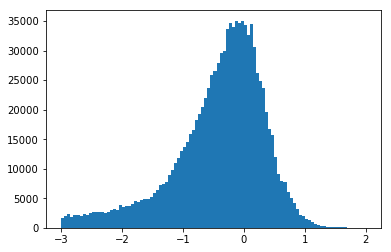

In [40]:
print(hdu.data.max())
print(hdu.data.min())
plt.hist(np.log10(hdu.data.flatten()), range=(-3, 2), bins=100 )
plt.show()

In [55]:
c = SkyCoord(ra=10.68458*u.degree, dec=41.26917*u.degree, distance=770*u.kpc)

In [60]:
distance = 30*u.Mpc

In [66]:
distance.to('cm')

<Quantity 9.257032744401575e+25 cm>

In [72]:
print(hdu.header['CDELT1'])
print(hdu.header['CUNIT1'])

9.42382812499999e+19
cm


In [88]:
cdelt1 = (hdu.header['CDELT1']*u.cm/distance.to('cm'))*u.rad.to('deg')
cdelt2 = (hdu.header['CDELT2']*u.cm/distance.to('cm'))*u.rad.to('deg')

In [90]:
print(-cdelt1, cdelt2)

-5.832814826605525e-05 cm / cm 5.832814826605525e-05 cm / cm


In [85]:
from astropy import wcs

# Setting up astrometry coordinates

In [115]:
w = wcs.WCS(naxis=2)

# reference pixel coordinate
w.wcs.crpix = [hdu.data.shape[0]/2,hdu.data.shape[1]/2]
# sizes of the pixel in degrees
w.wcs.cdelt = [-cdelt1, cdelt2]
# converting ra and dec into degrees
c = SkyCoord('19h59m28.3566s', '+40d44m02.096s')
w.wcs.crval = [c.ra.deg, c.dec.deg]

w.wcs.cunit = ['deg', 'deg']


In [117]:
header = w.to_header()
header
hdu.header.update(header)

In [118]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 4096                                                  
EXTEND  =                    T                                                  
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2                                                  
CRPIX1  =               2048.0                                                  
CRPIX2  =               1024.0                                                  
CDELT1  = -5.8328148266055E-

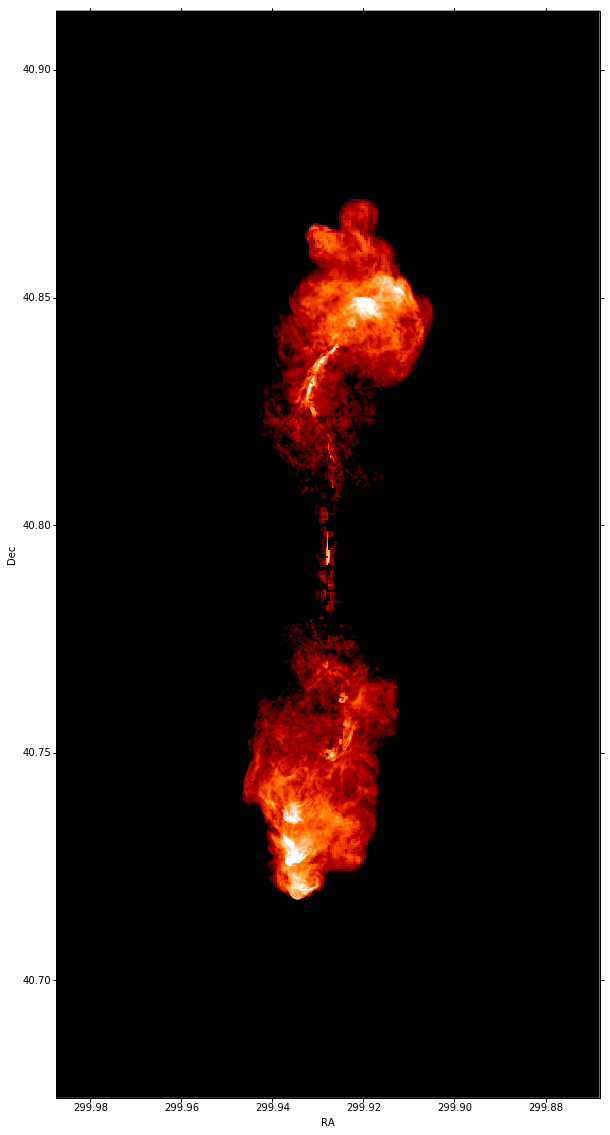

In [123]:
from astropy.wcs import WCS
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(10,20))
fig.add_subplot(111, projection=wcs)
plt.imshow(np.log10(hdu.data+1e-3), cmap='gist_heat', vmin=-1, vmax=1, origin='lower')#, cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [128]:
telescope_resolution=10*u.arcsecond
sigma=telescope_resolution.to('deg')/cdelt2
x_grid=np.linspace(-50,50,100)

In [127]:
gauss=np.exp(-(x_grid**2/(2.*sigma**2)))
psf=np.outer(gauss,gauss)
plt.imshow(psf)
plt.show()

TypeError: Can only apply 'exp' function to dimensionless quantities